# Example for dataset loading and analysis

This notebook will show a concrete example from my `Tacotron-2` model with the `SIWIS` dataset

Of course I will not post the dataset in the repo so pay attention to load it before executing the notebook !

It will be a 3 step processing with : 
1. **Encoding** : text encoding + mel-spectrogram loading
2. **Filtering** : filter audios longer than a given time
3. **Augmentation** : augment the input mel spectrogram

## 1) Imports and loading

In [1]:
import numpy as np
import tensorflow as tf

from utils import plot_spectrogram
from utils.audio import load_mel, TacotronSTFT
from utils.text import default_french_encoder
from datasets import get_dataset, print_datasets, prepare_dataset, test_dataset_time

In [2]:
text_encoder = default_french_encoder()

mel_fn = TacotronSTFT()
# Assumes the dataset is located at `D:/datasets/SIWIS`
# You can change the default position in `datasets/custom_datasets/__init__.py`
siwis = get_dataset('siwis')

print(text_encoder)
print(mel_fn)
print(siwis.head())
print("Dataset size : {}".format(len(siwis)))

Loading dataset siwis...
========== Text encoder ==========
Vocab (size = 72) : ['_', '-', '!', "'", '(', ')', ',', '.', ':', ';', '?', ' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
Config : {
  "level": 0,
  "cleaners": [
    "french_cleaners"
  ],
  "split_pattern": null,
  "pad_token": "",
  "ukn_token": null,
  "sos_token": "[SOS]",
  "eos_token": "[EOS]",
  "sub_word_prefix": "",
  "use_sos_and_eos": false
}

========== TacotronSTFT ==========
filter_length	: 1024
hop_length	: 256
win_length	: 1024
n_mel_channels	: 80
sampling_rate	: 22050
mel_fmin	: 0.0
mel_fmax	: 8000.0
normalize_mode	: None

                                                text  \
0  Benoît Hamon, monsieur le ministre, ce texte, ...   
1               Cette lutte se situe à deux niveaux.   
2                      Venons-en maintenant au fond.   
3              Peu à

## 2) Prepare processing pipeline

In [3]:
# These lengths correspond to approximately 10sec audio
max_input_length = 150
max_output_length = 1024
augment_prct = 0.25

def encode_text(text):
    if isinstance(text, tf.Tensor):
        text = text.numpy()
        if isinstance(text, (list, np.ndarray)):
            text = [p.decode('utf-8') for p in text]
        else:
            text = text.decode('utf-8')
    elif isinstance(text, bytes):
        text = text.decode('utf-8')
    
    return text_encoder.encode(text)
    
def decode_text(encoded):
    return text_encoder.decode(encoded)
        
def get_mel_input(data):
    mel = load_mel(data, mel_fn)
    # Add a `go_frame` (filled of 0) as 1st frame
    mel = tf.concat([tf.zeros((1, mel_fn.n_mel_channels), dtype = tf.float32), mel], axis = 0)
            
    return mel
    
def encode_data(data):
    """ Encode text + load spectrogram in `tensorflow graph mode` """
    encoded_text = tf.py_function(encode_text, [data['text']], Tout = tf.int32)
    encoded_text.set_shape([None])
        
    mel = get_mel_input(data)
    
    return encoded_text, len(encoded_text), mel, len(mel), mel
        
def filter_data(text, text_length, mel_input, mel_length, mel_output):
    """ Return `True` if audio and text are shorter than given thresholds """
    return tf.logical_and(text_length <= max_input_length, 
                          mel_length <= max_output_length)
    
def augment_mel(mel):
    """ Augment spectrogram given a probability (25% in this case) """
    return tf.cond(
        tf.random.uniform(()) < augment_prct,
        lambda: mel + tf.random.normal(tf.shape(mel)),
        lambda: mel
    )
        
def augment_data(text, text_length, mel_input, mel_length, mel_output):
    """ Augment mel input (but not mel output !) """
    mel_input = augment_mel(mel_input)
        
    return text, text_length, mel_input, mel_length, mel_output
    
def preprocess_data(text, text_length, mel_input, mel_length, mel_output):
    """ Remove `go_frame` from target and last frame from input (performed on padded batch) """
    mel_input   = mel_input[:, :-1]
    mel_output  = mel_output[:, 1:]
    
    return (text, text_length, mel_input, mel_length), mel_output


## 3) Build the dataset and test it

Here the `config` variable is typically something put in the `get_dataset_config()` method of the model

The `pad_before_map` says we want to batch before applying the `map_fn` argument (here the `preprocess_data`). This is important to remove last frames of datas but to remove padding frames

In reality the impact is more important in the real tacotron model where we need a `gate` variable which is 1 only for the latest frame so that we need to remove it after padding otherwise we remove the only 1 value

The `pad_values` is also more important with the `gate` as we can pad this particular variable with 1 instead of 0 (same for text we pad with `text_encoder.blank_token_idx`)

For the example I do not set the `shuffle_size` argument so that you can see the 1st text in 1st batch well corresponds to the 1st row in the `siwis` dataset

In [4]:
config = {
    'padded_batch' : True, # as data are variable length, we need padded batch
    'pad_kwargs' : { # here are the configuration for the padding
        'padded_shapes'     : (
            (None,), (), (None, mel_fn.n_mel_channels), (),
            (None, mel_fn.n_mel_channels)
        ),
        'padding_values'    : (text_encoder.blank_token_idx, 0, 0., 0, 0.)
    },
    'batch_before_map' : True
}

dataset = prepare_dataset(
    siwis,
    encode_fn  = encode_data,
    filter_fn  = filter_data,
    augment_fn = augment_data,
    map_fn     = preprocess_data,
    ** config,
    # shuffle_size = 1024,
    batch_size = 32, cache = False, prefetch = True, debug = True
)

Original dataset : <TensorSliceDataset shapes: {text: (), filename: (), time: (), mels_22050_chann-80_filt-1024_hop-256_win-1024_norm-None: (), wavs_16000: (), wavs_22050: (), wavs_44100: (), id: ()}, types: {text: tf.string, filename: tf.string, time: tf.float32, mels_22050_chann-80_filt-1024_hop-256_win-1024_norm-None: tf.string, wavs_16000: tf.string, wavs_22050: tf.string, wavs_44100: tf.string, id: tf.string}>
- Dataset after encoding : <ParallelMapDataset shapes: ((None,), (), (None, 80), (), (None, 80)), types: (tf.int32, tf.int32, tf.float32, tf.int32, tf.float32)>
- Dataset after filtering : <FilterDataset shapes: ((None,), (), (None, 80), (), (None, 80)), types: (tf.int32, tf.int32, tf.float32, tf.int32, tf.float32)>
- Dataset after augmentation : <ParallelMapDataset shapes: ((None,), (), (None, 80), (), (None, 80)), types: (tf.int32, tf.int32, tf.float32, tf.int32, tf.float32)>
- Dataset after batch : <PaddedBatchDataset shapes: ((None, None), (None,), (None, None, 80), (Non

Batch n°1
Text lengths : [65 36 29 37 60 54 70 77 38 26 89 51 64 46 87 27 31 39 78 48 50 81 34 52
 73 45 23 75 35 58 77 59]
Mel lengths : [412 189 163 215 334 286 423 368 205 132 505 327 336 258 566 153 194 207
 422 230 275 454 181 228 380 222 126 397 211 259 410 300]
Encoded text[0] : [39 42 51 52 46 57 11 45 38 50 52 51  6 11 50 52 51 56 46 42 58 55 11 49
 42 11 50 46 51 46 56 57 55 42  6 11 40 42 11 57 42 61 57 42  6 11 40  3
 42 56 57 11 59 52 57 55 42 11 53 55 52 47 42 57  7  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Decoded text[0] : benoit hamon, monsieur le ministre, ce texte, c'est votre projet.


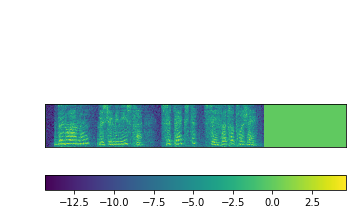

Batch n°2
Text lengths : [23 30 64 64 24 41 86 41 79 66 60 45 34 35 91 62 73 57 26 73 72 50 54 44
 45 56 57 43 90 61 44 42]
Mel lengths : [135 150 308 345 131 194 519 194 347 356 313 255 163 192 423 351 334 277
 191 288 333 240 237 194 250 283 303 262 434 324 220 222]
Encoded text[0] : [51 58 49 11 51 42 11 53 42 58 57 11 49  3 38 43 43 46 55 50 42 55  7  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Decoded text[0] : nul ne peut l'affirmer.


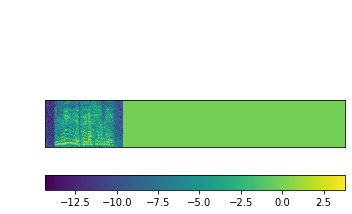

In [5]:
n = 2
for i, (inputs, outputs) in enumerate(dataset):
    if i >= n: break
    print("Batch n°{}".format(i+1))
    text, text_length, mel, mel_length = inputs
    
    print("Text lengths : {}".format(tf.squeeze(text_length)))
    print("Mel lengths : {}".format(tf.squeeze(mel_length)))
    
    print("Encoded text[0] : {}".format(text[0]))
    print("Decoded text[0] : {}".format(decode_text(text[0].numpy())))
    plot_spectrogram(spectrogram_0 = mel[0])

As we can see in plots, the white zone is the padding and the mel length well corresponds to the 1st value in mel length !

## 4) Testing performances

Now the pipeline is done we can test its performance ! 

The `test_dataset_time` generates `steps` (default 100) batches and compute the average time per batch. If weprovide the `batch_size`, it also computes the time to generate 1 single sample

At the end, if verbosity is set to `True`, it also shows shapes and types of the last generated batch

It also shows statistics on this batch which allows to check if values are consistent or not

Here we can see that : 
- Tokens goes from 0 to 69 as int32
- Text lengths are between 26 and 82 (for the latest batch)
- Mel inputs has values between -15 and 4 but output mel has values between -11 and 1.9 --> mels in this batch has been augmented
- Mel length are between 156 and 442

You can also see that it computes 100 batches in 4.649 seconds which is really fast ! It means 3200 mel-spectrogram computed, some ofthem augmented and 3200 text encoding !

In [6]:
_ = test_dataset_time(dataset, batch_size = 32)

99it [00:06, 15.27it/s]


100 batchs in 6.491 sec sec (15.406 batch / sec) (492.995 samples / sec)
Batch infos : 
Element 0 : 
 Element 0 : shape : (32, 82) - type : <dtype: 'int32'> - min : 0.000 - max : 69.000
 Element 1 : shape : (32,) - type : <dtype: 'int32'> - min : 26.000 - max : 82.000
 Element 2 : shape : (32, 441, 80) - type : <dtype: 'float32'> - min : -15.074 - max : 4.840
 Element 3 : shape : (32,) - type : <dtype: 'int32'> - min : 154.000 - max : 442.000
Element 1 : shape : (32, 441, 80) - type : <dtype: 'float32'> - min : -11.513 - max : 1.925


## List all available datasets

In [7]:
print_datasets()

Available keras datasets : ['cifar10', 'cifar100', 'fashion_mnist', 'imdb', 'mnist', 'reuters']
Available custom datasets : ['anime_faces', 'coco', 'common_voice', 'essex', 'europarl', 'fungi', 'kangaroo', 'librispeech', 'mls', 'raccoon', 'siwis', 'snli', 'squad', 'sts', 'voc', 'voxforge', 'wider', 'yolo_output']
